# Summary

In [1]:
%load_ext autoreload

import os
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.data as dataUtils

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [3]:
# options
# expt_id = '190424_f3'  # (run+feed)
# expt_id = '180824_f3r1'
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

dlc_array = dataUtils.load_dlc_from_csv(expt_id)
print('Loaded data from experiment %s' % expt_id)
print('n time points: %i' % dlc_array.shape[0])

/home/mattw/Dropbox/github/flygenvectors/flygenvectors/data.py:98: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dlc = genfromtxt(file_path, delimiter=',', dtype=None)


Loaded data from experiment 2019_07_01_fly2
n time points: 192980


### preprocess data - split into training/testing sets

In [4]:
# subtract off mean and divide by variance across all labels
xs = dlc_array[:, 0::3]
ys = dlc_array[:, 1::3]
overall_mean = np.mean(np.concatenate([xs, ys], axis=0))
overall_std = np.mean(np.concatenate([xs, ys], axis=0))
dlc_by_coord = dict(
#     x=(xs - overall_mean) / overall_std,
#     y=(ys - overall_mean) / overall_std,
    x=zscore(xs, axis=0),
    y=zscore(ys, axis=0),
    l=dlc_array[:, 2::3])
del xs
del ys
del dlc_array
# clean up single outliers
dlc_by_coord = dataUtils.clean_dlc_labels(dlc_by_coord, thresh=0.8)
dlc_array = np.concatenate([dlc_by_coord['x'], dlc_by_coord['y']], axis=1)

### check outliers

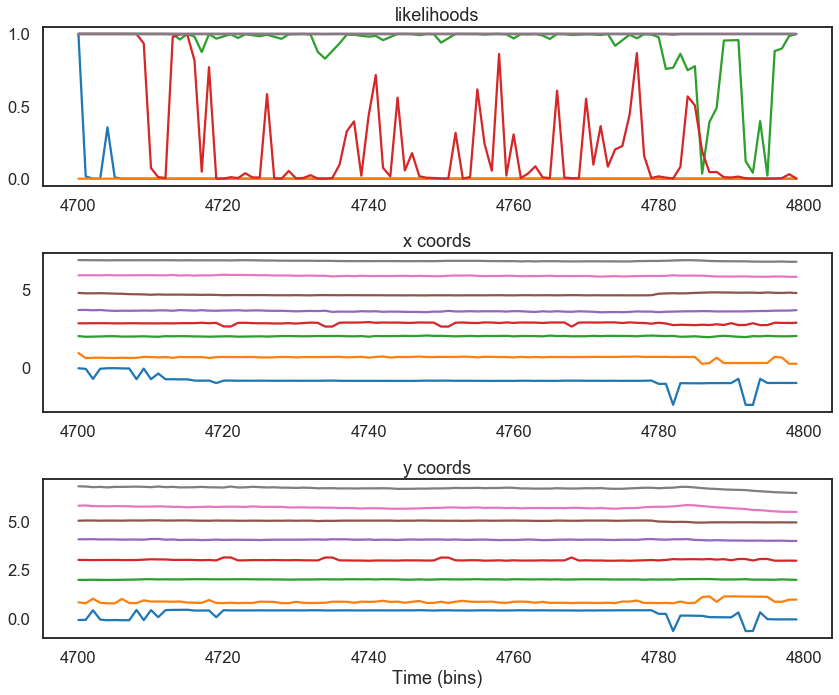

In [5]:
# plot dlc labels/likelihoods over time
slc = (4700, 4800)

plt.figure(figsize=(12, 10))

plt.subplot(311)
plt.plot(np.arange(slc[0], slc[1]), dlc_by_coord['l'][slice(*slc), :])
plt.title('likelihoods')

plt.subplot(312)
coord = 'x'
behavior = 4* dlc_by_coord[coord] / np.max(np.abs(dlc_by_coord[coord])) + \
    np.arange(dlc_by_coord[coord].shape[1])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.subplot(313)
coord = 'y'
behavior = 4* dlc_by_coord[coord] / np.max(np.abs(dlc_by_coord[coord])) + \
    np.arange(dlc_by_coord[coord].shape[1])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.xlabel('Time (bins)')
plt.tight_layout()
plt.show()

In [6]:
# percentage of time points below a certain threshold per label
thresh = 0.9
bad_frac = np.sum((dlc_by_coord['l'] < thresh) * 1.0, axis=0) / dlc_by_coord['l'].shape[0]
print(bad_frac)

[0.04015442 0.0992279  0.03264069 0.04244481 0.00751373 0.00501088
 0.         0.00070992]


In [7]:
# percentage of time points below a certain threshold for any label
thresh = 0.5
bad_frac = np.sum((np.min(dlc_by_coord['l'], axis=1) < thresh) * 1.0) / dlc_by_coord['l'].shape[0]
print(bad_frac)

0.11944242926728159


### split into train/test trials

In [8]:
# get runs with high likelihoods
indxs = utils.extract_high_likelihood_runs(
    dlc_by_coord['l'], l_thresh=0.0, min_length=100, max_length=500)

# split runs into train/test
indxs_dict = utils.split_runs(indxs, ['train', 'test', 'val'], [5, 0, 1])

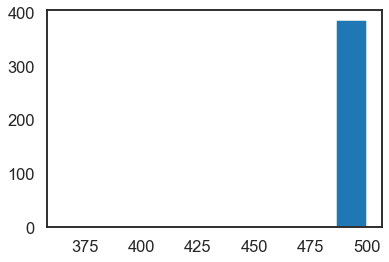

In [9]:
# plot distribution of run lengths
import matplotlib.pyplot as plt
plt.figure()
plt.hist([len(i) for i in indxs])
plt.show()

In [10]:
# split data into train/test using indices split above
dlc_dict = {dtype: [] for dtype in indxs_dict.keys()}
for dtype, dindxs in indxs_dict.items():
    for dindx in dindxs:
        dlc_dict[dtype].append(dlc_array[dindx, :])

# 2. Fit dynamics

### ARHMM - how many discrete states?

In [ ]:
n_states = [9] #np.arange(1, 9)
D = dlc_dict['train'][0].shape[1]
model_kwargs = {
#     'hmm': {
#         'transitions': 'standard', 
#         'observations': 'gaussian'},
#     'arhmm-s2': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e2},
#         'observations': 'ar'},
#     'arhmm-s4': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e4},
#         'observations': 'ar'},
#     'arhmm-s6': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e6},
#         'observations': 'ar'},
#     'arhmm-s8': {
#         'transitions': 'sticky', 
#         'transition_kwargs': {'kappa': 1e8},
#         'observations': 'ar'},
#     'arhmm': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-2': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 2}},
    'arhmm-3': {
        'transitions': 'standard', 
        'observations': 'ar',
        'observation_kwargs': {'lags': 3}},
#     'arhmm-5': {
#         'transitions': 'standard', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-r': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-r-3': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-r-5': {
#         'transitions': 'recurrent', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
#     'arhmm-ro': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 1}},
#     'arhmm-ro-3': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 3}},
#     'arhmm-ro-5': {
#         'transitions': 'recurrent_only', 
#         'observations': 'ar',
#         'observation_kwargs': {'lags': 5}},
}

fit_kwargs = {
    'save': True,
    'load_if_exists': True,
    'expt_id': expt_id,
    'model_dir': 'dlc-arhmm_label-zscore',
    'save_dir': None}

all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
#     if model_name in all_results and len(all_results[model_name] == n_states):
#         continue
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = utils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=dlc_dict['train'], data_val=dlc_dict['val'],
            data_test=dlc_dict['test'], fit_kwargs=fit_kwargs)
    all_results[model_name] = model_results

Fitting arhmm-3 with 9 states


In [ ]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_dict['val']]))
plt.legend(loc='lower right', frameon=False)

In [ ]:
# model_name = 'arhmm'
# K = 4
# arhmm = all_results[model_name][K]['model']

# # get most likely states
# states_all = arhmm.most_likely_states(data_dlc)
# # get probability of states
# states_prob = arhmm.expected_states(data_dlc)

# 3. Probe learned dynamics

### find multiple snippets of validation data for each state

In [ ]:
model_name = 'arhmm-3'
K = 9
dtype = 'train'
arhmm = all_results[model_name][K]['model']

In [ ]:
# infer all states and plot dlc lablels
%autoreload 2
import flygenvectors.plotting as plotting
slc = (0, 10000)
states_ = arhmm.most_likely_states(dlc_array)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_by_coord, state_probs=None, states=states_, slc=slc)

In [ ]:
# get most likely states
states_all = [arhmm.most_likely_states(d) for d in dlc_dict[dtype]]

# collect all state snippets
indx_snippets = utils.extract_state_runs(states_all, indxs_dict[dtype], min_length=10)

# get dlc labels
dlc_snippets = [{'x': [], 'y': []} for _ in range(K)]
state_lengths = [[] for _ in range(K)]
for k, k_indxs in enumerate(indx_snippets):
    for k_indx in k_indxs:
        state_lengths[k].append(len(k_indx))
        for coord in ['x', 'y']:
            dlc_snippets[k][coord].append(dlc_by_coord[coord][k_indx])        
state_lengths = [np.array(state_lengths[k]) for k in range(K)]

In [ ]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

In [ ]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

In [ ]:
fig = plotting.make_syllable_plots(dlc_snippets, max_snippets=5, max_t=100, coord='y')

# 4. Load videos

In [ ]:
video = dataUtils.load_video(expt_id)

In [ ]:
# %autoreload 2
# import flygenvectors.plotting as plotting
save_file = str('/home/mattw/results/fly/%s/K=%02i_label-zscore.mp4' % (expt_id, K))
plotting.make_syllable_movie(
    save_file, states_all, video, indxs_dict[dtype], single_state=None,
    min_threshold=5, n_pre_frames=1, n_buffer=10)